<a href="https://colab.research.google.com/gist/proppy/26525ff7d9810247759a8d3ff3c41dcb/openlane-with-conda-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenLane flow with conda-eda packages

## install conda

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh")

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:31
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()
!sed -i -e /cudatoolkit/d /usr/local/conda-meta/pinned

✨🍰✨ Everything looks OK!


## Install conda-eda packages

In [ ]:
!conda install -y -c litex-hub -c conda-forge open_pdks.sky130a=1.0.290 magic openroad netgen yosys gdstk

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gdstk
    - magic
    - netgen
    - open_pdks.sky130a=1.0.290
    - openroad
    - yosys


The following packages will be downloaded:

    package                    |  

## Get OpenLane

and workaround a few dependencies quirk and container specific setup

In [ ]:
!git clone https://github.com/The-OpenROAD-Project/OpenLane
!apt-get update && apt-get install -yq tcllib
!python -m pip install pyyaml click pandas

Cloning into 'OpenLane'...
remote: Enumerating objects: 13827, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 13827 (delta 0), reused 1 (delta 0), pack-reused 13825
Receiving objects: 100% (13827/13827), 836.76 MiB | 39.25 MiB/s, done.
Resolving deltas: 100% (10021/10021), done.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machin

## Run OpenLane Flow

- disable CVC because of https://github.com/hdl/conda-eda/issues/174
- disable klayout because of https://github.com/hdl/conda-eda/issues/175
- allow missmatch because of https://github.com/The-OpenROAD-Project/OpenLane/issues/923

In [ ]:
%env PDK_ROOT=/usr/local/share/pdk
%env OPENLANE_ROOT=/content/OpenLane
!OPENLANE_LOCAL_INSTALL=1 \
 MISMATCHES_OK=1 \
 TCLLIBPATH=/usr/share/tcltk \
 LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/lib \
 PATH=$PATH:$OPENLANE_ROOT:$OPENLANE_ROOT/scripts \
 flow.tcl -design inverter \
 -override_env RUN_KLAYOUT=0,RUN_CVC=0,MISMATCHES_OK=1

env: PDK_ROOT=/usr/local/share/pdk
env: OPENLANE_ROOT=/content/OpenLane
[INFO]: 
	___   ____   ___  ____   _       ____  ____     ___
	/   \ |    \ /  _]|    \ | |     /    ||    \   /  _]
	|   | |  o  )  [_ |  _  || |    |  o  ||  _  | /  [_
	| O | |   _/    _]|  |  || |___ |     ||  |  ||    _]
	|   | |  | |   [_ |  |  ||     ||  _  ||  |  ||   [_
	\___/ |__| |_____||__|__||_____||__|__||__|__||_____|


[INFO]: Version: 2022.03.03_02.36.44-1-gd49a0b6
[INFO]: Running non-interactively
[INFO]: Using design configuration at /content/OpenLane/designs/inverter/config.tcl
[INFO]: Sourcing Configurations from /content/OpenLane/designs/inverter/config.tcl
[INFO]: PDKs root directory: /usr/local/share/pdk
[INFO]: PDK: sky130A
[INFO]: Setting PDKPATH to /usr/local/share/pdk/sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library is set to: sky130_fd_sc_hd
[INFO]: Sourcing Configurations from /content/OpenLane/designs/inverter/config.tcl
[INFO]: Current

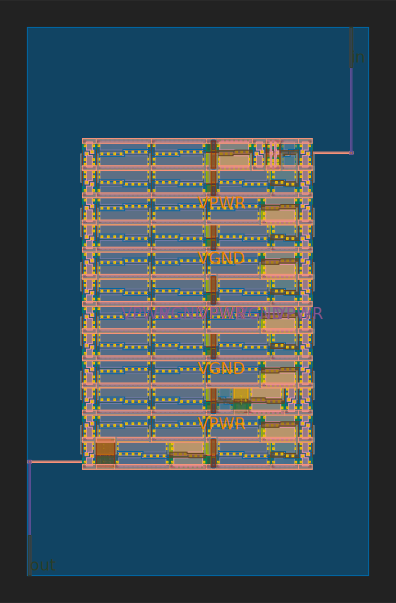

In [ ]:
import pathlib
import gdstk
from IPython.display import SVG

gds = sorted(pathlib.Path('OpenLane/designs/inverter/runs').glob('*/results/final/gds/*.gds'))[0]
library = gdstk.read_gds(gds)
top_cells = library.top_level()
top_cells[0].write_svg('inverter.svg')
SVG('inverter.svg')